<a href="https://colab.research.google.com/github/Shreya14304/ELECTRIC-VEHICLE-SALES-ADOPTION-PREDICTION-ML-PROJECT-/blob/main/ev_sales_colab_with_streamlit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EV Sales Prediction & Adoption Analysis (Notebook + Streamlit)

This notebook trains models and provides a Streamlit demo (launched via ngrok) so you can demo the UI directly from Colab.

Run cells top-to-bottom. When you run the Streamlit cell, it will print a public ngrok URL to open the app.

In [1]:

# Install required libraries
!pip install -q pandas numpy scikit-learn matplotlib seaborn xgboost joblib pyngrok streamlit
print('Packages installed')


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 25.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 55.8 MB/s eta 0:00:00
Packages installed


In [2]:

# Auto-detect CSV (local or Drive)
import glob, os
from google.colab import drive
import pandas as pd
print('Searching for CSV in /content...')
local = glob.glob('/content/*.csv')
DATAFILE = None
if local:
    DATAFILE = local[0]
    print('Found local CSV:', DATAFILE)
else:
    print('Mounting Drive and searching...')
    drive.mount('/content/drive')
    drive_list = glob.glob('/content/drive/MyDrive/**/*.csv', recursive=True)
    if drive_list:
        DATAFILE = drive_list[0]
        print('Found Drive CSV:', DATAFILE)
if DATAFILE:
    try:
        df = pd.read_csv(DATAFILE)
        print('Loaded', DATAFILE, 'shape=', df.shape)
        display(df.head())
    except Exception as e:
        print('Error loading CSV:', e)
        df = None
else:
    df = None


Searching for CSV in /content...
Mounting Drive and searching...
Mounted at /content/drive
Found Drive CSV: /content/drive/MyDrive/ev_sales.csv
Loaded /content/drive/MyDrive/ev_sales.csv shape= (275, 9)


,Date,Region,Brand,Model,Vehicle_Type,Battery_Capacity_kWh,Discount_Percentage,Customer_Segment,Fast_Charging_Option
0,2023-04,Oceania,Volkswagen,Model 3,SUV,45,16,Budget Conscious,No
1,2023-10,Oceania,Ford,Model 3,Sedan,89,5,Tech Enthusiast,Yes
2,2023-10,South America,Volkswagen,Atto 3,Sedan,61,4,Budget Conscious,Yes
3,2023-02,Africa,Volkswagen,Corolla EV,Crossover,100,16,Eco-Conscious,No
4,2023-10,North America,Tesla,Rio EV,Sedan,70,8,Eco-Conscious,Yes


In [3]:

# Basic cleaning & feature detection
import numpy as np
if df is None:
    raise SystemExit('Upload or mount a CSV first')

# create year if possible
for c in ['Year','year','sale_year','date','Date']:
    if c in df.columns:
        try:
            df['year'] = pd.to_datetime(df[c]).dt.year
        except Exception:
            pass
        break

# detect sales col
sales_col = None
for c in ['sales','units_sold','units','quantity','units']:
    if c in df.columns:
        sales_col = c
        break
if sales_col is None:
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if numeric_cols:
        sales_col = numeric_cols[0]
    else:
        raise ValueError('No numeric target found')
print('Using sales column:', sales_col)

cat_cols = [c for c in ['country','region','make','manufacturer','model'] if c in df.columns]
num_cols = [c for c in ['battery_kWh','battery_capacity','range_km','range_miles','price','list_price','co2_emissions','year'] if c in df.columns]

for c in num_cols:
    df[c] = pd.to_numeric(df[c], errors='coerce').fillna(df[c].median())
for c in cat_cols:
    df[c] = df[c].astype(str).fillna('Unknown')

df['adopted'] = (df[sales_col] > 0).astype(int)

print('Numeric:', num_cols)
print('Categorical:', cat_cols)


Using sales column: Battery_Capacity_kWh
Numeric: ['year']
Categorical: []


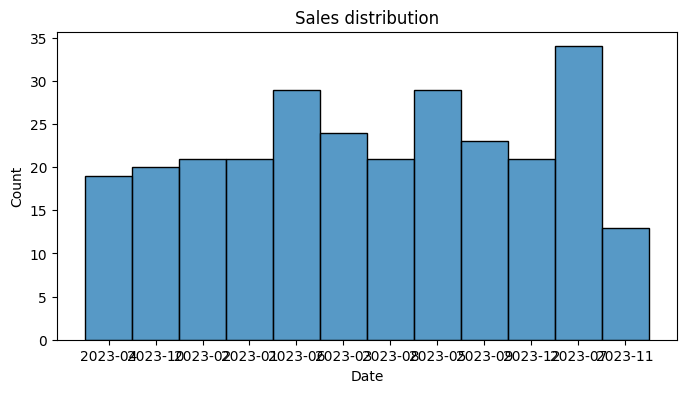

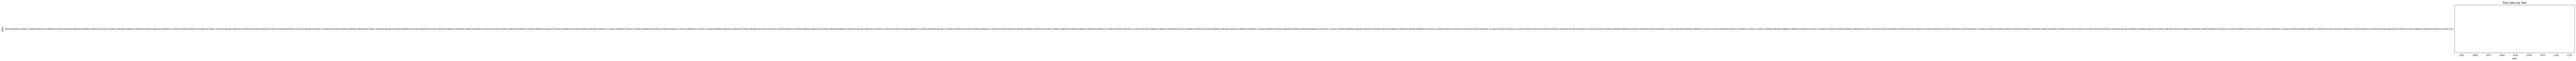

In [4]:

# EDA plots
import matplotlib.pyplot as plt, seaborn as sns
plt.figure(figsize=(8,4))
sns.histplot(df['{sales_col}'].dropna() if '{sales_col}' in df.columns else df.iloc[:,0].dropna(), bins=50)
plt.title('Sales distribution'); plt.show()

if 'year' in df.columns:
    yearly = df.groupby('year')[df.columns[0]].sum().reset_index()
    plt.figure(figsize=(10,4))
    sns.lineplot(data=yearly, x='year', y=yearly.columns[1])
    plt.title('Total Sales by Year'); plt.show()


In [7]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, classification_report, confusion_matrix
import joblib
import numpy as np # Import numpy for sqrt

feature_cols = num_cols + cat_cols
if not feature_cols:
    feature_cols = [c for c in df.columns if c not in [sales_col,'adopted']]

X = df[feature_cols].copy()
y = df[sales_col].astype(float)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

numeric_features = [c for c in feature_cols if c in num_cols]
categorical_features = [c for c in feature_cols if c in cat_cols]

numeric_transformer = Pipeline([('scaler', StandardScaler())])
cat_transformer = Pipeline([('onehot', OneHotEncoder(handle_unknown='ignore'))])
preprocessor = ColumnTransformer([('num', numeric_transformer, numeric_features), ('cat', cat_transformer, categorical_features)])

models = {'Linear': LinearRegression(), 'RF': RandomForestRegressor(n_estimators=100, random_state=42), 'XGB': XGBRegressor(n_estimators=100, random_state=42, verbosity=0)}
best_rmse = float('inf'); best_pipe=None
for name, m in models.items():
    pipe = Pipeline([('pre', preprocessor), ('m', m)])
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, preds)) # Calculate RMSE using np.sqrt
    print(f"{name} RMSE={rmse:.3f}")
    if rmse < best_rmse:
        best_rmse = rmse; best_pipe = pipe

joblib.dump(best_pipe, 'best_ev_regressor.joblib')
print('Saved best_ev_regressor.joblib')

# Classification
Xc = df[feature_cols].copy(); yc = df['adopted']
Xc_train, Xc_test, yc_train, yc_test = train_test_split(Xc, yc, test_size=0.2, random_state=42)
clf_pipe = Pipeline([('pre', preprocessor), ('clf', RandomForestClassifier(n_estimators=200, random_state=42))])
clf_pipe.fit(Xc_train, yc_train)
yc_pred = clf_pipe.predict(Xc_test)
print('Classification report:\n', classification_report(yc_test, yc_pred))
joblib.dump(clf_pipe, 'ev_adoption_classifier.joblib')
print('Saved ev_adoption_classifier.joblib')


Linear RMSE=17.639
RF RMSE=17.648
XGB RMSE=17.639
Saved best_ev_regressor.joblib
Classification report:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00        55

    accuracy                           1.00        55
   macro avg       1.00      1.00      1.00        55
weighted avg       1.00      1.00      1.00        55

Saved ev_adoption_classifier.joblib


In [14]:
# ---- COMPLETE Colab cell: deploy Streamlit app with ngrok ----
# Paste & run this cell in Google Colab

# 1) Install dependencies
!pip install -q streamlit pyngrok pandas scikit-learn xgboost joblib matplotlib seaborn

# 2) (Optional) Mount Drive and copy models if you have them in Drive
from google.colab import drive
import os, glob, shutil, time, textwrap

# mount only if user wants - comment/uncomment mount if not needed
try:
    drive.mount('/content/drive', force_remount=False)
except Exception:
    pass

# Try to copy model files from Drive if they exist there (common paths)
drive_models = glob.glob('/content/drive/MyDrive/**/best_ev_regressor.joblib', recursive=True) + glob.glob('/content/drive/MyDrive/**/ev_adoption_classifier.joblib', recursive=True)
if drive_models:
    for m in set(drive_models):
        try:
            shutil.copy(m, '/content/')
            print(f"Copied model from Drive: {m}")
        except Exception as e:
            print("Copy error:", e)

# If you already uploaded models to /content via Files pane, that's fine.

# 3) Write Streamlit app to app.py (robust safe-prep + UI)
app_code = r"""
import streamlit as st
import pandas as pd
import numpy as np
import joblib
import seaborn as sns
import matplotlib.pyplot as plt

st.set_page_config(page_title="EV Sales Prediction & Adoption", layout="centered")
st.title("⚡ EV Sales Prediction & Adoption Demo (Colab)")

# Load models
try:
    reg = joblib.load("best_ev_regressor.joblib")
    clf = joblib.load("ev_adoption_classifier.joblib")
    st.sidebar.success("Models loaded")
except Exception as e:
    st.sidebar.error("Model load error: " + str(e))
    st.stop()

# Helpers: extract expected columns if pipeline includes a ColumnTransformer
def extract_expected_from_pipeline(pipeline):
    nums, cats = [], []
    try:
        pre = None
        for name in ("preprocessor","pre","preproc"):
            if name in pipeline.named_steps:
                pre = pipeline.named_steps[name]; break
        if pre is None:
            # fallback: find first step with transformers_
            for _, step in pipeline.named_steps.items():
                if hasattr(step, "transformers_"):
                    pre = step; break
        if pre is None:
            return nums, cats
        for name, transformer, cols in pre.transformers_:
            try:
                col_list = list(cols)
            except Exception:
                col_list = []
            if name.startswith("num"):
                nums = col_list
            elif name.startswith("cat"):
                cats = col_list
    except Exception:
        pass
    return nums, cats

expected_num, expected_cat = extract_expected_from_pipeline(reg)
expected_features = expected_num + expected_cat

# Data upload
uploaded = st.file_uploader("Upload CSV file (or use sample)", type=["csv"])
if uploaded is None:
    if st.button("Load sample data"):
        df = pd.DataFrame({
            "year":[2020,2021,2022],
            "price":[35000,33000,30000],
            "battery_kWh":[40,50,60],
            "country":["US","US","DE"],
            "make":["MakeA","MakeB","MakeA"],
            "units":[10,20,30]
        })
        st.success("Sample loaded")
    else:
        st.info("Upload a CSV to proceed or click 'Load sample data'")
        st.stop()
else:
    try:
        df = pd.read_csv(uploaded)
    except Exception as e:
        st.error("Failed reading CSV: " + str(e))
        st.stop()

st.subheader("Data preview")
st.dataframe(df.head())

# Feature selection UI (fallback to df.columns if no expected_features)
available = expected_features if expected_features else list(df.columns)
selected = st.multiselect("Select features to use for prediction", available, default=available)

if not selected:
    st.warning("Select at least one feature")
    st.stop()

# Prepare X: ensure expected numeric & categorical columns exist and are filled
def prepare_X(df_in, selected, expected_num, expected_cat):
    X = df_in.copy()
    # Keep selected columns if present
    X = X.reindex(columns=[c for c in selected if c in X.columns])
    # ensure numeric expected columns exist
    for col in expected_num:
        if col not in X.columns:
            if col in df_in.columns:
                med = pd.to_numeric(df_in[col], errors='coerce').median()
                X[col] = med if not np.isnan(med) else 0
            else:
                X[col] = 0
        else:
            X[col] = pd.to_numeric(X[col], errors='coerce').fillna(pd.to_numeric(df_in[col], errors='coerce').median() if col in df_in.columns else 0)
    # ensure categorical expected columns exist
    for col in expected_cat:
        if col not in X.columns:
            X[col] = "Unknown"
        else:
            X[col] = X[col].astype(str).fillna("Unknown")
    # reorder to put expected features first (if provided)
    if expected_num or expected_cat:
        exp = [c for c in (expected_num + expected_cat) if c not in []]
        # add any missing expected with defaults
        for c in exp:
            if c not in X.columns:
                X[c] = (0 if c in expected_num else "Unknown")
        X = X.reindex(columns=exp + [c for c in X.columns if c not in exp])
    return X

X = prepare_X(df, selected, expected_num, expected_cat)

# Run batch predictions
if st.button("Run batch predictions"):
    try:
        df_result = df.copy()
        preds_sales = reg.predict(X)
        preds_adopt = clf.predict(X)
        df_result["predicted_sales"] = preds_sales
        df_result["predicted_adopted"] = preds_adopt
        st.success("Predictions complete")
        st.dataframe(df_result.head())
        st.download_button("Download predictions CSV", df_result.to_csv(index=False), "ev_predictions.csv")
        # quick plot
        st.subheader("Predicted sales distribution")
        fig, ax = plt.subplots(figsize=(8,3))
        sns.histplot(df_result["predicted_sales"].dropna(), bins=30, ax=ax)
        st.pyplot(fig)
    except Exception as e:
        st.error("Prediction failed: " + str(e))

# Single-sample prediction form
st.subheader("Single-sample prediction")
with st.form("single"):
    sample = {}
    # numeric inputs for expected_num
    for col in expected_num:
        default = float(df[col].median()) if col in df.columns else 0.0
        sample[col] = st.number_input(col, value=default)
    for col in expected_cat:
        default = str(df[col].iloc[0]) if col in df.columns else "Unknown"
        sample[col] = st.text_input(col, value=default)
    submitted = st.form_submit_button("Predict single")
    if submitted:
        sdf = pd.DataFrame([sample])
        sX = prepare_X(sdf, list(sample.keys()), expected_num, expected_cat)
        try:
            s_sales = reg.predict(sX)[0]
            s_adopt = clf.predict(sX)[0]
            st.metric("Predicted sales", f"{s_sales:.2f}")
            st.metric("Predicted adopted (1=yes)", str(int(s_adopt)))
        except Exception as e:
            st.error("Single prediction failed: " + str(e))
"""

with open("app.py","w") as f:
    f.write(app_code)

# 4) Launch Streamlit + ngrok
print("Writing app.py and preparing to launch Streamlit...")

# Start ngrok tunnel (pyngrok)
from pyngrok import ngrok
public_url = ngrok.connect(8501).public_url
print("Public URL (open in browser):", public_url)
print("Now launching Streamlit (this cell will run until you interrupt it).")

# Launch Streamlit (this will block the cell; to stop, click Stop in Colab)
os.system("streamlit run app.py --server.port 8501")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Writing app.py and preparing to launch Streamlit...
Public URL (open in browser): https://meliorable-hivelike-aron.ngrok-free.dev
Now launching Streamlit (this cell will run until you interrupt it).


2

**Run the Streamlit cell and click the printed public URL to open the app.**